### Capstone 1 - Washington state linkage of infant death, birth, and mother's hospitalization discharge data

##### Maya Bhat-Gregerson

 December 8, 2019

The purpose of this project is to use machine learning methods to link infant deaths occurring in Washington State to the infants' birth records and also to the mothers' hospitalization records within one year prior to birth.  Having a dataset of linked health information for Washington State residents allows us to conduct analyses that may yield valuable insights into maternal factors correlated with infant mortality.

Birth records contain the mothers' names and other identifiers, so in theory it should be possible to link the birth records to hospital discharge data using the mothers information.

There should be a 1:1 match between birth and death records.  Each hospitalization data row represents one hospital visit and it is possible that an individual can have multiple hospital visits in the period of interest.  Linkage between birth and mother's hospitalization records will be a 1:many join.

## 1. Clean data in preparation for linkage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### a. Death data

In [2]:
#Read in 2018 death data

dth18 = pd.read_csv(r'...\infdth2018_raw.csv', 
                    index_col = None,
                    low_memory = False)

#### GENERAL INFO ABOUT DEATH DATA FRAME

In [3]:
# variable info - name and type

pd.set_option('display.max_rows', 140)

dth18.dtypes

sfn               int64
birthsfn         object
ssn              object
fname            object
mname            object
lname            object
mom_fname        object
mom_mname        object
mom_lname        object
sex              object
agetype         float64
age               int64
ageyrs          float64
dob              object
dobm              int64
dobd              int64
doby              int64
dod              object
dodm              int64
dodd              int64
dody              int64
dodmod           object
todhh             int64
todmm             int64
todmod           object
bplstatefips     object
bcountryl        object
dcityl           object
dcountyl         object
dstatel          object
dzip             object
dplacetype      float64
dfaccd            int64
bridgerace        int64
hispno           object
rcity            object
rcityfips         int64
rcitylim         object
rcountyl         object
rcntyfips         int64
rstatefips       object
rzip            

In [5]:
dth18.shape

(58282, 42)

In [6]:
dth18['age'].describe

<bound method NDFrame.describe of 0        81
1        85
2        88
3        85
4        84
         ..
58277    60
58278    45
58279    92
58280    60
58281    90
Name: age, Length: 58282, dtype: int64>

In [7]:
dth18['rstatefips'].value_counts(dropna=False)

WA    56916
OR      486
ID      202
CA      106
AK       99
MT       55
XX       39
ZZ       34
AZ       34
TX       31
FL       27
NV       19
BC       15
HI       15
NY       15
IL       14
MI       13
CO       13
OK       11
UT       10
NJ        8
MO        7
PA        7
AL        7
VA        6
NC        6
IN        6
SD        5
OH        5
MS        5
MN        5
GA        4
SC        4
TN        4
IA        3
WY        3
CT        3
WI        3
NM        3
ON        3
WV        3
ND        3
MA        3
KS        2
MD        2
AB        2
LA        2
NH        2
AR        2
ME        2
DE        1
KY        1
DC        1
MP        1
AS        1
YT        1
GU        1
NE        1
Name: rstatefips, dtype: int64

#### LIMIT TO INFANTS WHO WERE WASHINGTON STATE RESIDENTS
Infants are defined as less than 365 days old at the time of death.

In [8]:
## restrict to infants defined as <=365 days old at time of death who were residents of Washington State.
## code selects all 'agetype' values other than 1.  Agetype = 1 indicates age is in years. Infant age would be recorded as
## 'agetype' values 2 through 5 i.e. months, days, hours, or minutes.

infdth18 = dth18[(dth18['rstatefips'] == "WA") & (dth18['agetype'] != 1)]

In [9]:
infdth18.shape

(401, 42)

In [10]:
pd.crosstab(infdth18.agetype, infdth18.rstatefips, dropna=False)

#All decedents are Washington State residents. Age types are minutes, days,
#weeks and months.

rstatefips,WA
agetype,
2.0,131
3.0,111
4.0,94
5.0,65


In [11]:
infdth18['age'].value_counts(dropna=False)

1     84
2     66
3     33
4     29
7     22
5     21
6     19
8     15
15    10
9     10
11     9
12     9
13     7
23     6
24     6
17     5
21     5
10     4
20     4
22     4
30     4
18     3
16     3
26     2
14     2
35     2
44     2
40     2
54     1
43     1
53     1
49     1
48     1
45     1
33     1
37     1
25     1
31     1
28     1
27     1
56     1
Name: age, dtype: int64

#### CHECK FOR NULL AND OUT OF RANGE VALUES

In [14]:
infdth18.isna().sum()

# no missing values in any variable EXCEPT decedent middle name and mother's middle name
# will exclude these from linkage

sfn               0
birthsfn          1
ssn               0
fname             0
mname            74
lname             0
mom_fname         0
mom_mname       197
mom_lname         0
sex               0
agetype           0
age               0
ageyrs            0
dob               0
dobm              0
dobd              0
doby              0
dod               0
dodm              0
dodd              0
dody              0
dodmod            0
todhh             0
todmm             0
todmod            0
bplstatefips      0
bcountryl         0
dcityl            0
dcountyl          0
dstatel           0
dzip              0
dplacetype        0
dfaccd            0
bridgerace        0
hispno            0
rcity             0
rcityfips         0
rcitylim          0
rcountyl          0
rcntyfips         0
rstatefips        0
rzip              0
dtype: int64

Probably will not use mothers' and infants' middle name for linking as there are too many missing values.

#### CREATE SUBSET CONSISTING OF LINKING VARIABLES IN DEATH DATA

In [15]:
# create subset of death linking variables: decedent's first and last names, mother's first and last
# name, decedents date of birth, decedent's sex, residence county and city, and decedent's SSN.

dthlinkvars = infdth18.loc[:,['sfn', 'birthsfn', 'ssn', 'fname', 'lname', 'mom_fname', 'mom_lname', 
                              'dobm', 'dobd', 'doby', 'dob', 'sex', 'rcityfips', 'rcity', 'rcntyfips', 
                              'rcountyl', 'dstatel']]

dthlinkvars.reset_index(drop=True, inplace=True)

In [16]:
## CHECK FOR OUT OF RANGE VALUES - RESTRICT TO VARIABLES THAT WILL BE USED FOR LINKING AT THIS POINT

In [60]:
#create dictionary of valid values so that each variable can be checked to make sure there is no
# out of range value.

valids = {'sex': ['M', 'F', 'U'],
          'dobm': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 99],
          'dobd': np.r_[1:32 ,99],
          'doby': [2017,2018],
         'rcntyfips': np.r_[range(1, 78, 2), 99]}

In [18]:
# check for out of range values for 'sex'

chksex = dthlinkvars['sex'].isin(valids['sex'])
len(dthlinkvars[~chksex])

0

In [19]:
# check for out of range values for 'dobm'

chkdobm = dthlinkvars['dobm'].isin(valids['dobm'])
len(dthlinkvars[~chkdobm])

0

In [20]:
# check for out of range values for 'doby'

chkdoby = dthlinkvars['doby'].isin(valids['doby'])
len(dthlinkvars[~chkdoby])

0

In [21]:
# check for out of range values for 'dobd'

chkdobd = dthlinkvars['dobd'].isin(valids['dobd'])
len(dthlinkvars[~chkdobd])


0

In [22]:
# check for out of range values for 'dobd'

chkrcounty = dthlinkvars['rcntyfips'].isin(valids['rcntyfips'])
len(dthlinkvars[~chkrcounty])

2

In [23]:
rcntyerrors = dthlinkvars[~chkrcounty][['sfn','rcntyfips', 'rcountyl', 'rcntyfips','dstatel']]

rcntyerrors

,sfn,rcntyfips,rcountyl,rcntyfips,dstatel
262,2018043748,999,UNKNOWN,999,WASHINGTON
347,2018057560,999,UNKNOWN,999,WASHINGTON


In [24]:
dthlinkvars.loc[dthlinkvars.sfn == 2018057560, 'rcountyl'] ="SNOHOMISH"
dthlinkvars.loc[dthlinkvars.sfn == 2018057560, 'rcntyfips'] = 61
dthlinkvars[dthlinkvars.sfn == 2018057560]['rcntyfips']

347    61
Name: rcntyfips, dtype: int64

In [25]:
#repeating check on residence county out of range values

chkrcounty = dthlinkvars['rcntyfips'].isin(valids['rcntyfips'])
len(dthlinkvars[~chkrcounty])
rcntyerrors = dthlinkvars[~chkrcounty][['sfn','rcntyfips', 'rcountyl', 'rcntyfips','dstatel']]

rcntyerrors

,sfn,rcntyfips,rcountyl,rcntyfips,dstatel
262,2018043748,999,UNKNOWN,999,WASHINGTON


After looking up the record with unknown residence county values in the SQL database I found that there is no additional information available to correct this record.  Linkage of this record will rely on other variables with complete information.

### b. Birth data 2017, 2018

In [55]:
#Read in 2017-18 birth data

bir1718 = pd.read_csv(r'...\bir2017_18_raw.csv', 
                    index_col = None,
                    low_memory = False)

In [56]:
bir1718.dtypes

bsfn               object
bcerttype          object
bfname             object
bmname             object
blname             object
bmom_fname         object
bmom_mname         object
bmom_lname         object
bsex               object
bdob               object
bdobm               int64
bdobd               int64
bdoby               int64
bplstatefips       object
b_momrcity         object
b_momrcityfips      int64
b_momrcountyl      object
b_momrcntyfips      int64
b_momrstatefips    object
b_momrzip          object
dtype: object

I limited the birth data set to linkage variables while executing the SQL query.  I also limited the dataset to births occurring in 2017 and 2018 where either the birthplace state was Washington or the mother's residence state was Washington.

In [57]:
birlinkvars = bir1718
bir1718.shape

(175984, 20)

In [58]:
## CHECK FOR OUT OF RANGE VALUES - RESTRICT TO VARIABLES THAT WILL BE USED FOR LINKING AT THIS POINT

In [62]:
# check for out of range values for 'bsex'

chkbsex = birlinkvars['bsex'].isin(valids['sex'])
len(birlinkvars[~chkbsex])

0

In [63]:
# check for out of range values for 'bdobm'

chkbdobm = birlinkvars['bdobm'].isin(valids['dobm'])
len(birlinkvars[~chkbdobm])

0

In [64]:
# check for out of range values for 'bdoby'

chkbdoby = birlinkvars['bdoby'].isin(valids['doby'])
len(birlinkvars[~chkbdoby])

0

In [65]:
# check for out of range values for 'bdobd'

chkbdobd = birlinkvars['bdobd'].isin(valids['dobd'])
len(birlinkvars[~chkbdobd])

0

In [66]:
# check for out of range values for 'b_momrcntyfips'

chkbrcounty = birlinkvars['b_momrcntyfips'].isin(valids['rcntyfips'])
len(birlinkvars[~chkbrcounty])

383

In [67]:
brcntyerrors = birlinkvars[~chkbrcounty][['bsfn','b_momrcntyfips', 'b_momrcountyl','b_momrstatefips']]

brcntyerrors.head()

,bsfn,b_momrcntyfips,b_momrcountyl,b_momrstatefips
547,2018075748R,130,KETCHIKAN GATEWAY,AK
1016,2017901464O,999,CLARK,WA
1082,2017902337O,999,STEVENS,WA
1083,2017902336O,999,SNOHOMISH,WA
1084,2017902338O,999,CLARK,WA


In [68]:
#Create dictionary of Washington State county names and county FIPS codes 

counties = {'ADAMS':1,
'ASOTIN':3,
'BENTON':5,
'CHELAN':7,
'CLALLAM':9,
'CLARK':11,
'COLUMBIA':13,
'COWLITZ':15,
'DOUGLAS':17,
'FERRY':19,
'FRANKLIN':21,
'GARFIELD':23,
'GRANT':25,
'GRAYS HARBOR':27,
'ISLAND':29,
'JEFFERSON':31,
'KING':33,
'KITSAP':35,
'KITTITAS':37,
'KLICKITAT':39,
'LEWIS':41,
'LINCOLN':43,
'MASON':45,
'OKANOGAN':47,
'PACIFIC':49,
'PEND OREILLE':51,
'PIERCE':53,
'SAN JUAN':55,
'SKAGIT':57,
'SKAMANIA':59,
'SNOHOMISH':61,
'SPOKANE':63,
'STEVENS':65,
'THURSTON':67,
'WAHKIAKUM':69,
'WALLA WALLA':71,
'WHATCOM':73,
'WHITMAN':75,
'YAKIMA':77
}


In [69]:
birlinkvars['b_momrcntyfips']=birlinkvars['b_momrcountyl'].map(counties)

In [70]:
birlinkvars['b_momrcntyfips'].value_counts(dropna=False)

33.0    49609
53.0    22756
61.0    19631
63.0    11616
11.0    10998
77.0     7476
67.0     6176
35.0     5972
5.0      5119
73.0     4325
21.0     3087
25.0     2939
57.0     2817
15.0     2528
NaN      2318
29.0     1813
41.0     1766
7.0      1703
27.0     1455
45.0     1277
9.0      1259
71.0     1217
17.0     1048
47.0      975
65.0      862
37.0      829
75.0      780
1.0       776
3.0       439
39.0      434
31.0      354
49.0      353
51.0      234
43.0      217
13.0      215
59.0      195
55.0      170
19.0      135
69.0       63
23.0       48
Name: b_momrcntyfips, dtype: int64

In [71]:
cntyfips = birlinkvars['b_momrcountyl'].map(counties)
birlinkvars["b_momrcntyfips"].fillna(cntyfips, inplace=True)

In [43]:
birlinkvars['b_momrcntyfips'].value_counts(dropna=False)

33.0    49609
53.0    22756
61.0    19631
63.0    11616
11.0    10998
77.0     7476
67.0     6176
35.0     5972
5.0      5119
73.0     4325
21.0     3087
25.0     2939
57.0     2817
15.0     2528
NaN      2318
29.0     1813
41.0     1766
7.0      1703
27.0     1455
45.0     1277
9.0      1259
71.0     1217
17.0     1048
47.0      975
65.0      862
37.0      829
75.0      780
1.0       776
3.0       439
39.0      434
31.0      354
49.0      353
51.0      234
43.0      217
13.0      215
59.0      195
55.0      170
19.0      135
69.0       63
23.0       48
Name: b_momrcntyfips, dtype: int64

In [72]:
birlinkvars[(birlinkvars['b_momrcntyfips'].isnull()) & (birlinkvars['b_momrstatefips']=="WA")][['b_momrstatefips', 'b_momrcntyfips', 'b_momrcountyl']]

,b_momrstatefips,b_momrcntyfips,b_momrcountyl
1094,WA,NaN,
1095,WA,NaN,
2739,WA,NaN,
7649,WA,NaN,
10849,WA,NaN,UNKNOWN
19413,WA,NaN,UNKNOWN
20850,WA,NaN,UNKNOWN
21527,WA,NaN,UNKNOWN
29243,WA,NaN,UNKNOWN
29909,WA,NaN,UNKNOWN


In [73]:
# checking for all missing variables
birlinkvars.isna().sum()

bsfn                   0
bcerttype              0
bfname                16
bmname             17231
blname                11
bmom_fname           146
bmom_mname         28431
bmom_lname           788
bsex                   0
bdob                   0
bdobm                  0
bdobd                  0
bdoby                  0
bplstatefips           0
b_momrcity             0
b_momrcityfips         0
b_momrcountyl          0
b_momrcntyfips      2318
b_momrstatefips        0
b_momrzip              0
dtype: int64

There is no **easy** way to find mom's county of residence (literal or code).  Will leave these in data for now.

Once again, middle names for baby and mother are missing.  Interestingly mother's last name is missing for 788 of the almost 176,000 birth records.  For now, I will not do anything with these until I try to link death and birth records.

### c. Hospital discharge data 2016-2018

The hospital discharge data set is formally known as Comprehensive Hospital Abstract Reporting System (CHARS). The dataset contains hospital discharge information. Each time an individual is discharged from a hospital after an inpatient or outpatient visit a record is created.  It is possible for an individual to be present multiple times in the data if they have had multiple hospital visits.

In [10]:
# Read in and process 2016 CHARS data

chars16 = pd.read_sas(r"...\full2016.sas7bdat", encoding = "utf-8")

In [11]:
chars16.shape

(649996, 108)

In [12]:
pd.set_option('display.max_rows', 140)
chars16.dtypes

SEQ_NO                       object
REC_KEY                     float64
STAYTYPE                     object
HOSPITAL                     object
LINENO                      float64
ZIPCODE                      object
ZIPPLUS4                     object
STATERES                     object
COUNTYRES                    object
COUNTRY                      object
AGE                         float64
DOB                  datetime64[ns]
SEX                          object
ADM_DATE             datetime64[ns]
ADM_HR                       object
DIS_DATE             datetime64[ns]
DIS_HR                       object
LENSTAYD                    float64
LENSTAYH                    float64
ADM_TYPE                     object
ADM_SRC                      object
STATUS                       object
CHARGES                     float64
PAYER1                       object
PAYER2                       object
PAYER3                       object
DIAGCNT                     float64
DIAG1                       

In [14]:
pd.crosstab(chars16.STATERES, chars16.SEX)

SEX,F,M
STATERES,,
AE,5,1
AK,1148,1485
AL,14,16
AP,0,2
AR,14,18
AS,5,4
AZ,215,218
CA,618,696
CO,91,86


In [18]:
chars16['AGE'].describe()

count    649994.000000
mean         47.629053
std          28.147859
min          -0.000000
25%          27.000000
50%          53.000000
75%          70.000000
max         116.000000
Name: AGE, dtype: float64

Limiting CHARS 2016 data set by keeping records of females between ages 10 and 60 who were residents  of WA.

In [41]:
chars16lim = chars16[(chars16['STATERES'] == 'WA') & (chars16['SEX']=='F') & (chars16['AGE']>10) & (chars16['AGE']<60)]

In [42]:
chars16lim.shape

(175071, 108)

In [43]:
pd.crosstab(chars16lim['STATERES'], chars16lim['SEX'])

SEX,F
STATERES,
WA,175071


Repeating the same process as with CHARS 2016 for 2017 and 2018 also.  After subsets of all three years of CHARS data are created I will append them vertically to create one dataset covering 2016-18.

In [36]:
#Read in and process 2017

chars17 = pd.read_sas(r"Y:\DQSS\Death\MBG\Py\Data\full2017.sas7bdat", encoding = "utf-8")

In [37]:
chars17.shape

(655078, 108)

In [38]:
chars17lim = chars17[(chars17['STATERES'] == 'WA') & (chars17['SEX']=='F') & (chars17['AGE']>10) & (chars17['AGE']<60)]

In [39]:
chars17lim.shape

(171755, 108)

In [40]:
pd.crosstab(chars17lim['STATERES'], chars17lim['SEX'])

SEX,F
STATERES,
WA,171755


In [44]:
#Read in and process 2018

chars18 = pd.read_sas(r"Y:\DQSS\Death\MBG\Py\Data\full2018.sas7bdat", encoding = "utf-8")

In [45]:
chars18.shape

(644416, 108)

In [46]:
chars18lim = chars18[(chars18['STATERES'] == 'WA') & (chars18['SEX']=='F') & (chars18['AGE']>10) & (chars18['AGE']<60)]

In [47]:
chars18lim.shape

(167398, 108)

In [48]:
pd.crosstab(chars18lim['STATERES'], chars18lim['SEX'])

SEX,F
STATERES,
WA,167398


In [51]:
# Append the three CHARS limited data sets.

chars1617 = chars16lim.append(chars17lim)
chars16_18 = chars1617.append(chars18lim)

In [52]:
# check that all three years are present in the combined data set
# date range and total number of records in results below
chars16_18['DIS_DATE'].describe


<bound method NDFrame.describe of 3        2016-01-10
4        2016-01-07
12       2016-01-07
14       2016-01-04
16       2016-01-03
            ...    
644390   2018-11-11
644392   2018-12-06
644396   2018-12-21
644402   2018-12-13
644404   2018-12-01
Name: DIS_DATE, Length: 514224, dtype: datetime64[ns]>

In [75]:
chars16_18.isna().sum()

SEQ_NO                    0
REC_KEY                   0
STAYTYPE                  0
HOSPITAL                  0
LINENO                    0
ZIPCODE                   0
ZIPPLUS4             441018
STATERES                  0
COUNTYRES                 0
COUNTRY              514224
AGE                       0
DOB                       0
SEX                       0
ADM_DATE                  0
ADM_HR                    1
DIS_DATE                  0
DIS_HR                    1
LENSTAYD                  0
LENSTAYH              71662
ADM_TYPE                  0
ADM_SRC                   0
STATUS                    0
CHARGES                   0
PAYER1                    0
PAYER2               421946
PAYER3               508945
DIAGCNT                   0
DIAG1                     0
DIAG2                  5068
DIAG3                 15016
DIAG4                 48952
DIAG5                 95963
DIAG6                147624
DIAG7                198232
DIAG8                244648
DIAG9               

In [79]:
charscols = chars16_18.columns
charscols

Index(['SEQ_NO', 'REC_KEY', 'STAYTYPE', 'HOSPITAL', 'LINENO', 'ZIPCODE',
       'ZIPPLUS4', 'STATERES', 'COUNTYRES', 'COUNTRY',
       ...
       'MDC_POA', 'BILLTYPE', 'AWEEKEND', 'AGE_MONTH', 'ADMF_DATE', 'AGE_O',
       'LENSTAYD_O', 'AWEEKEND_O', 'AGE_MONTH_O', 'DISCHARGERECORDID'],
      dtype='object', length=108)

In [84]:
#DROP variables with all missing/mostly missing values as these are of no use.
chars16_18lim = chars16_18.drop(['COUNTRY', 'ZIPPLUS4', 'IDOTHER2', 'IDOTH2_S', 
                             'ECODECAL', 'DRG2', 'DRG_WT2', 'ADMF_DATE', 'AGE_O', 
                             'LENSTAYD_O', 'AWEEKEND_O', 'AGE_MONTH_O'], axis=1)

## 2. Decriptive analysis

##### DATA VISUALIZATION

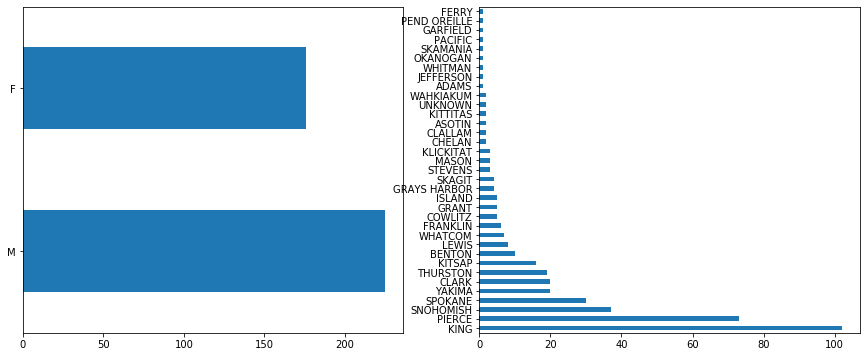

In [165]:
# Plot death variables sex, residence county
# ********need to plot proportion of total rather than just counts*******

plt.figure(figsize = (15,6))

plt.subplot(121)
dthlinkvars.sex.value_counts().plot(kind='barh')
plt.subplot(122)
dthlinkvars.rcountyl.value_counts().plot(kind='barh')